In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import sys
from pathlib import Path
if "../src" not in sys.path:
    sys.path.append("../src")
import dietcoke
from tqdm.auto import tqdm
import numpy as np
import os, psutil
from scipy.sparse import load_npz
from matplotlib import pyplot as plt
from scipy.stats import entropy

In [3]:
vocab = dietcoke.Vocabulary("../data/diach_vocab/vocab_210928.txt")

In [4]:
SPMAT_BASEDIR = Path("../data/coocur_mat/win5")
def select_spmat(dynspan, winsize):
    sp_path = SPMAT_BASEDIR / f"sparse_mat_{dynspan}_contextSize{winsize}.npz"
    if sp_path.exists():
        return sp_path
    else:
        raise FileNotFoundError()

In [5]:
TARGET_WORDS = "江水日月之乎者也"
DYNSPANS="先秦,漢,魏晉南北,唐五代十國,宋元,明,清".split(",")
entropy_mat = np.zeros((len(TARGET_WORDS), len(DYNSPANS)))
variance_mat = np.zeros((len(TARGET_WORDS), len(DYNSPANS)))
ctypes_vec = np.zeros(len(DYNSPANS), dtype=np.int64)
ctokens_vec = np.zeros(len(DYNSPANS), dtype=np.int64)

In [8]:
sp = load_npz(select_spmat("先秦", 5))

In [13]:
for dynspan_i, dynspan_x in tqdm(enumerate(DYNSPANS)):
    spmat = load_npz(select_spmat(dynspan_x, 5))
    for word_i, word_x in enumerate(TARGET_WORDS):
        row_x = np.array(spmat.getrow(vocab[word_x]).log1p().todense()).squeeze()
        row_x = row_x/row_x.sum()
        entropy_mat[word_i, dynspan_i] = entropy(row_x)
        variance_mat[word_i, dynspan_i] = np.var(row_x)    
        ctypes_vec[dynspan_i] = np.sum(np.diff(spmat.indptr)!=0)
        ctokens_vec[dynspan_i] = np.sum(spmat.diagonal())

Text(0, 0.5, 'charac. tokens (log10)')

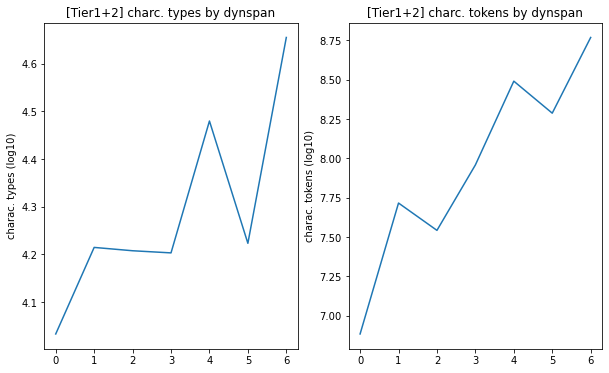

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].plot(np.log10(ctypes_vec))
axes[0].set_title("[Tier1+2] charc. types by dynspan")
axes[0].set_ylabel("charac. types (log10)")
axes[1].plot(np.log10(ctokens_vec))
axes[1].set_title("[Tier1+2] charc. tokens by dynspan")
axes[1].set_ylabel("charac. tokens (log10)")

entropy@dyn0:  之 8.60 也 8.53 者 8.21 日 7.66 乎 7.58 水 7.54 月 7.12 江 6.69
variance@dyn0:  江 2.8e-08 月 1.8e-08 水 1.2e-08 乎 1.1e-08 日 1e-08 者 5.8e-09 也 4e-09 之 3.8e-09


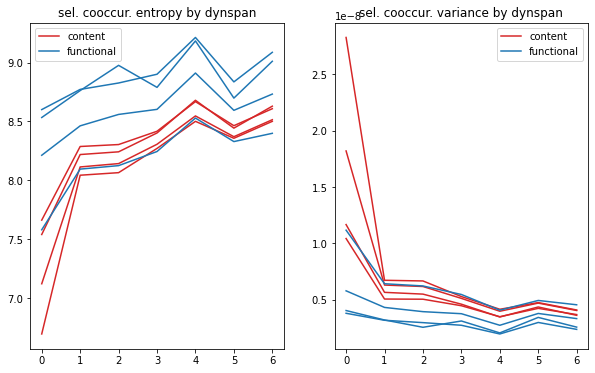

In [31]:

fig, axes = plt.subplots(1, 2, figsize=(10,6))
lines = []
for word_i in range(entropy_mat.shape[0]):
    if word_i < 4:
        col = "tab:red"
    else:
        col = "tab:blue"
    ln0 = axes[0].plot(entropy_mat[word_i, :], color=col)
    ln1 = axes[1].plot(variance_mat[word_i, :], color=col)
    
    if word_i in (0, 4):
        lines.append(ln0[0])                    
axes[0].legend(lines, ["content", "functional"])
axes[1].legend(lines, ["content", "functional"])
axes[0].set_title("sel. cooccur. entropy by dynspan")
axes[1].set_title("sel. cooccur. variance by dynspan")

print("entropy@dyn0: ", " ".join(f"{TARGET_WORDS[i]} {entropy_mat[i, 0]:.2f}" 
                for i in np.argsort(-entropy_mat[:, 0])))
print("variance@dyn0: ", " ".join(f"{TARGET_WORDS[i]} {variance_mat[i, 0]:.2g}" 
                for i in np.argsort(-variance_mat[:, 0])))